# Домашнее задание о векторизации текстов

В задании вам предстоит сравнить несколько методов снижения размерности
* PCA
* t-SNE

а так же попробовать осуществить тематическое моделирование методом LDA.

**Формат сдачи задания** -- указание в гуглформе ссылки на тетрадь с решением + ответ на вопросы (см. последние вопросы первой задачи) в форме. Форма появится ближе к дедлайну.

**Дедлайн** 23.59 7 октября MSK.  

ДЗ предполагает возможность получения **до 12 баллов** по десятибалльной шкале. Оценки 11 и 12 поступают в ведомость, как оценки 11 и 12.

---

Если вы уже хорошо знакомы с снижением размерности, реализуйте первую задачу, используя не Bag-of-Words векторы текстов, а эмбеддинги текстов, полученные алгоритмом на ваш выбор. 
**Если вы собираетесь решать задачу так, то, приступая, сообщите об этом @oserikov в телеграме.**

Если вы уже хорошо знакомы ещё и с векторизацией текстов эмбеддингами, напишите @oserikov для обсуждения замены первой задачи на другую.


# [6 баллов] Задача о снижении размерности




[Вот](https://drive.google.com/drive/folders/1HX5rz4UZHtbzhPguUFolOg-xm6HFc0KO?usp=sharing) корпус, однажды собранный без особенных размышлений.
Это -- корпус любительской литературы. Он был собран для забавы и непонятно, какая природа у представленных там текстов.

Вам предстоит оценить, насколько эти тексты интересны в качестве простого датасета для задачи классификации: информативны ли Bag-of-Words векторы в смысле разделения текстов по жанрам.

---

### Постановка задачи

**Задача**: взяв фанифики и два каких-то других жанра из корпуса, визуализировать их BoW-представления на плоскости.

---

Визуализацию стоит осуществлять scatter-плотом, информацию о принадлежности документа какому-то жанру стоит передавать цветом.

Количество документов, представляющих каждый жанр, стоит подобрать семплированием нужного количества элементов под доступные вычислительные ресурсы -- полный корпус точно слишком велик.

Гиперпараметры BoW-векторизатора стоит подобрать под доступные вычислительные ресурсы -- если код работает дольше часа, то стоит упростить вычислительную задачу: подобрать другие гиперпараметры векторизации или уменьшить выборку.

#### Критерии


* **1 БАЛЛ**: 
  * В выбранных документах осуществлена какая-то **стандартная предобработка текста**: удалены стоп-слова и мусорные токены (e.g. html-теги), проведена лемматизация.  
  Решение о каждой конкретной детали предобработки остаётся на усмотрение студентов: каждое нестандартное действие (e.g. отказ от лемматизации или удаление каких-то особенных токенов) стоит пояснить коротким комментарием, описывающим мотивацию.
  * Получены **Bag-of-Words векторы** документов, выбранных для исследования. 
* **1 БАЛЛ**: получена визуализация документов на плоскости **методом главных компонент** снижения размерности Bag-of-Words векторов.
* **1 БАЛЛ**: получена визуализация документов на плоскости методом **t-SNE** снижения размерности Bag-of-Words векторов.
* **1 БАЛЛ**: на полученных визуализациях **получилось передать цветом точек классы** документов; понятно, точка какого цвета относится к какому классу.


Скорее всего визуализация t-SNE и PCA заметно отличаются раскладкой точек по плоскости: один метод как будто раскладывает их вдоль двух пересекающихся прямых, за другим такого свойства скорее всего нет. Ответ на два вопроса ниже вам предстоит указать в гуглформе, сдавая задание.
* **1 БАЛЛ**: верно указано, какой метод укладывает точки примерно вдоль прямых, а какой -- нет
* **1 БАЛЛ**: предложено верное описание тому, почему у одного из методов всегда результаты располагаются вдоль некоторых прямых. 



##### Препроцессинг

In [2]:
import os
import re
import pandas as pd

In [12]:
fant = []
posmod = []
fanfic = []


def read_files(filename, source):
    with open(filename, "r", encoding='utf-8') as file:
        content = file.read()
        source.append(content)
        

for dirpath, dirnames, filenames in os.walk("."):
    for filename in filenames:
        if dirpath == './Фэнтези':
            read_files(os.path.join(dirpath, filename), fant)
        if dirpath == './Фанфик' or dirpath == './Фанфик2':
            read_files(os.path.join(dirpath, filename), fanfic)
        if dirpath == './Постмодернизм':
            read_files(os.path.join(dirpath, filename), posmod)

In [13]:
ff_df = pd.DataFrame(fanfic, columns=['text'])
ff_df['genre'] = 'фанфик'

post_df = pd.DataFrame(posmod, columns=['text'])
post_df['genre'] = 'постмодернизм'

fant_df = pd.DataFrame(fant, columns=['text'])
fant_df['genre'] = 'фэнтези'

In [17]:
data = pd.concat([ff_df, post_df, fant_df], ignore_index=True)

In [44]:
data['genre'].value_counts()

фэнтези          1007
постмодернизм    1007
фанфик           1007
Name: genre, dtype: int64

In [20]:
!python -m pip install --quiet razdel pymorphy2[fast]

You should consider upgrading via the '/Users/macbook/anaconda3/bin/python -m pip install --upgrade pip' command.


In [9]:
from razdel import tokenize

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macbook/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
from nltk.corpus import stopwords

In [29]:
def get_tokens(text):
    """
    убираем токены и пунктуацию
    """
    tokenized_text = tokenize(text)
    tokens = list(tokenized_text)
    text_token = [_.text for _ in tokens]
    text_end = ' '.join(
            [wrd.lower() for wrd in text_token if wrd.lower() not in stopwords.words(
                "russian")])
    
    # для удаления тегов
    p = re.compile(r'<.*?>')
    new_text = p.sub('', text_end)
    line = "".join(l for l in new_text if l not in (
        '.', ',', '[', ']', '', '«', '»', '±', '№',
        '/', '#',  '_', '%', '@', '^', '&', '*',
        '?', '!', ':', ';', '—', '--', '<', '>', '"', '(', ')'))
    return line

In [7]:
from tqdm.auto import tqdm

In [30]:
tokenizing_texts = []
for text in tqdm(data['text']):
    tokenizing_texts.append(get_tokens(text))

In [32]:
data["tokenized_text"] = tokenizing_texts

In [34]:
# записываем в файл

data.to_csv('all_texts.csv', sep="\t")

In [35]:
from pymorphy2 import MorphAnalyzer

morph = MorphAnalyzer()

In [36]:
def get_lemmas(text):
    new_l = ''
    
    for word in text.split():
        wrd = morph.parse(word)[0]
        new_l += wrd.normal_form + ' '

    """
    мне казалось странным удаление "-", потому что
    оно есть среди таких слов как как-то, кто-то и т.д.,
    но для лемматизации, наверное, лучше удалить, но тогда
    как и то склеятся
    """
    
    line = new_l.replace('-', '')
    return line

In [37]:
lemmatized_texts = []
for text in tqdm(data["tokenized_text"]):
    lemmatized_texts.append(get_lemmas(text))

In [38]:
data["lemmatized_text"] = lemmatized_texts

In [42]:
data

,text,tokenized_text,lemmatized_text,genre
0,"\nГлава 1\nЛайелл Люпин, широко улыбаясь, шел ...",глава 1 лайелл люпин широко улыбаясь шел кор...,глава 1 лайелл люпин широко улыбаться идти кор...,фанфик
1,"\n\n \n \n\n\n\n\n\nПролог\n\n\n \n Убийца, мо...",пролог убийца монстр террорист называли раз...,пролог убийца монстр террорист называть разный...,фанфик
2,\n\nМолодая женщина и мужчина немного старше н...,молодая женщина мужчина немного старше нетороп...,молодая женщина мужчина немного старший неторо...,фанфик
3,\n\n\n\n\nГлава 10\n\n-Регион Юнова? - спрашив...,глава 10 -регион юнова - спрашиваю профессора...,глава 10 регион юновый спрашивать профессор ...,фанфик
4,\nSword Art Online. Отстраненность со вкусом ш...,sword art online отстраненность вкусом шокола...,sword art online отстраненность вкус шоколад 6...,фанфик
...,...,...,...,...
3016,"\nСтуденты, всё таки пришедшие в количестве се...",студенты всё таки пришедшие количестве семи ш...,студент весь таки прийти количество семь штука...,фэнтези
3017,\n\n\n\n\n\n\n\n\n\n \n \n\n\n\n\n\nАвтор шифр...,автор шифруется капелька вина - астра нак...,автор шифроваться капелька вино астр наконецт...,фэнтези
3018,"\n\n\n \n \n\n\n\n Рич.\n -Доброе утро, Япония...",рич - доброе утро япония - радио будильнике...,рич добрый утро япония радио будильник ненав...,фэнтези
3019,\n\n \n \n\n\n\n -Интересная точка зрения... -...,- интересная точка зрения - улыбнулась импера...,интересный точка зрение улыбнуться императри...,фэнтези


In [43]:
# записываем в файл

data.to_csv('all_texts_before_graf.csv', sep="\t")

##### Визуализация

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

По аналогии с примером, который был приложен к дз, я поигралась с максимальными значениями и, чтобы получился плюс-минус красивый реузультат, уменьшила значения max_features до 20 тысяч с 62, что позволило значительно сократить время работы функций  tsne и pca

In [324]:
vectorizer = TfidfVectorizer(
#    analyzer='word',  # дефолт -- документация
    min_df = 5,
    max_df = 0.97,
    max_features = 20000
)

matr = vectorizer.fit_transform(data['lemmatized_text'])

In [325]:
matr.shape

(3021, 20000)

In [326]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [327]:
# делаем PCA

pca = PCA(n_components=2).fit_transform(matr.todense())

In [311]:
pca.shape

(3021, 2)

In [328]:
principalDf = pd.DataFrame(pca,
                           columns = ['principal component 1', 'principal component 2'])

In [329]:
finalDf = pd.concat([principalDf, data[['genre']]], axis = 1)

In [330]:
finalDf

,principal component 1,principal component 2,genre
0,0.075756,0.033166,фанфик
1,0.255504,-0.057111,фанфик
2,0.049840,-0.028109,фанфик
3,-0.105863,-0.007266,фанфик
4,0.151817,-0.040297,фанфик
...,...,...,...
3016,0.003026,-0.024388,фэнтези
3017,-0.148242,-0.006122,фэнтези
3018,0.049606,-0.016108,фэнтези
3019,0.130093,-0.027077,фэнтези


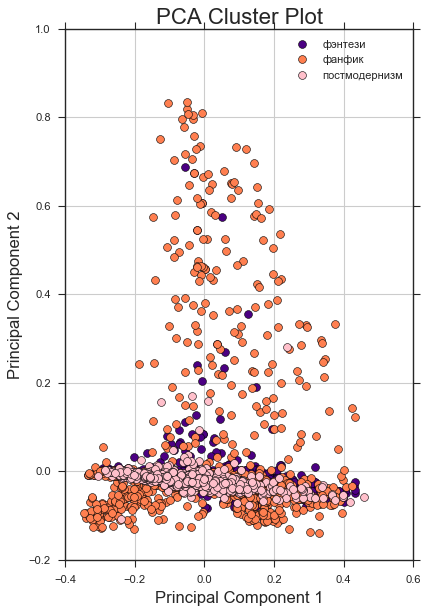

In [349]:
fig = plt.figure(figsize = (5,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA Cluster Plot', fontsize = 20)

targets = ['фэнтези', 'фанфик', 'постмодернизм']
colors = ['indigo', 'coral', 'pink']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['genre'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [332]:
# делаем tsne
tsne = TSNE(n_components=2).fit_transform((matr.todense()))

In [333]:
tsne.shape

(3021, 2)

In [334]:
tsne_df_1 = pd.DataFrame(tsne,
                         columns = ['component 1', 'component 2'])

In [335]:
tsne_df = pd.concat([tsne_df_1, data[['genre']]], axis = 1)

In [336]:
tsne_df

,component 1,component 2,genre
0,30.250677,5.645778,фанфик
1,-6.591821,-2.896128,фанфик
2,0.836684,11.439446,фанфик
3,17.793406,-48.101475,фанфик
4,-26.019337,-0.489267,фанфик
...,...,...,...
3016,29.757679,-23.773359,фэнтези
3017,8.813421,-17.439486,фэнтези
3018,2.288345,5.159187,фэнтези
3019,-30.121786,2.765832,фэнтези


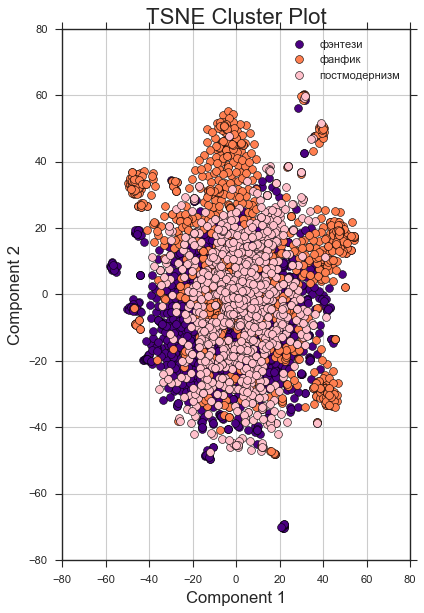

In [348]:
fig = plt.figure(figsize = (5,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('TSNE Cluster Plot', fontsize = 20)

targets = ['фэнтези', 'фанфик', 'постмодернизм']
colors = ['indigo', 'coral', 'pink']
for target, color in zip(targets, colors):
    indicesToKeep = tsne_df['genre'] == target
    ax.scatter(tsne_df.loc[indicesToKeep, 'component 1']
               , tsne_df.loc[indicesToKeep, 'component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

На kaggle был еще такой вариант: tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(matr.todense()))
    он работает значительно быстрее, но не очень понятно из условия, можно ли его использовать, поэтому я попробовала сделать это также, как было в примере, чтобы он просто был:

In [340]:
tsne2 = TSNE().fit_transform(PCA(n_components=50).fit_transform(matr.todense())) 

In [341]:
tsne.shape

(3021, 2)

In [343]:
tsne_df_2 = pd.DataFrame(tsne2,
                         columns = ['component 1', 'component 2'])
tsne_df2 = pd.concat([tsne_df_2, data[['genre']]], axis = 1)

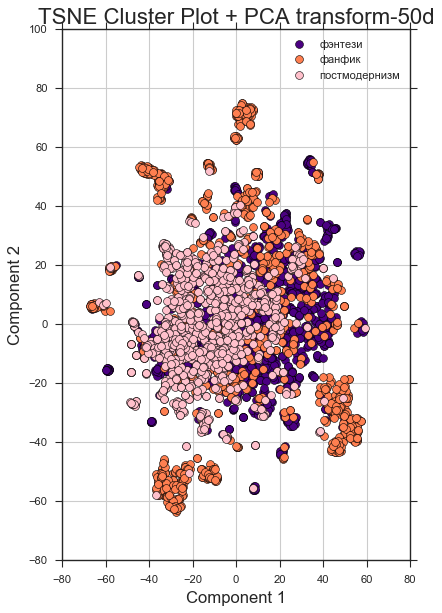

In [347]:
fig = plt.figure(figsize = (5,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('TSNE Cluster Plot + PCA transform-50d', fontsize = 20)

targets = ['фэнтези', 'фанфик', 'постмодернизм']
colors = ['indigo', 'coral', 'pink']
for target, color in zip(targets, colors):
    indicesToKeep = tsne_df2['genre'] == target
    ax.scatter(tsne_df2.loc[indicesToKeep, 'component 1']
               , tsne_df2.loc[indicesToKeep, 'component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [338]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style


style.use('seaborn-ticks')

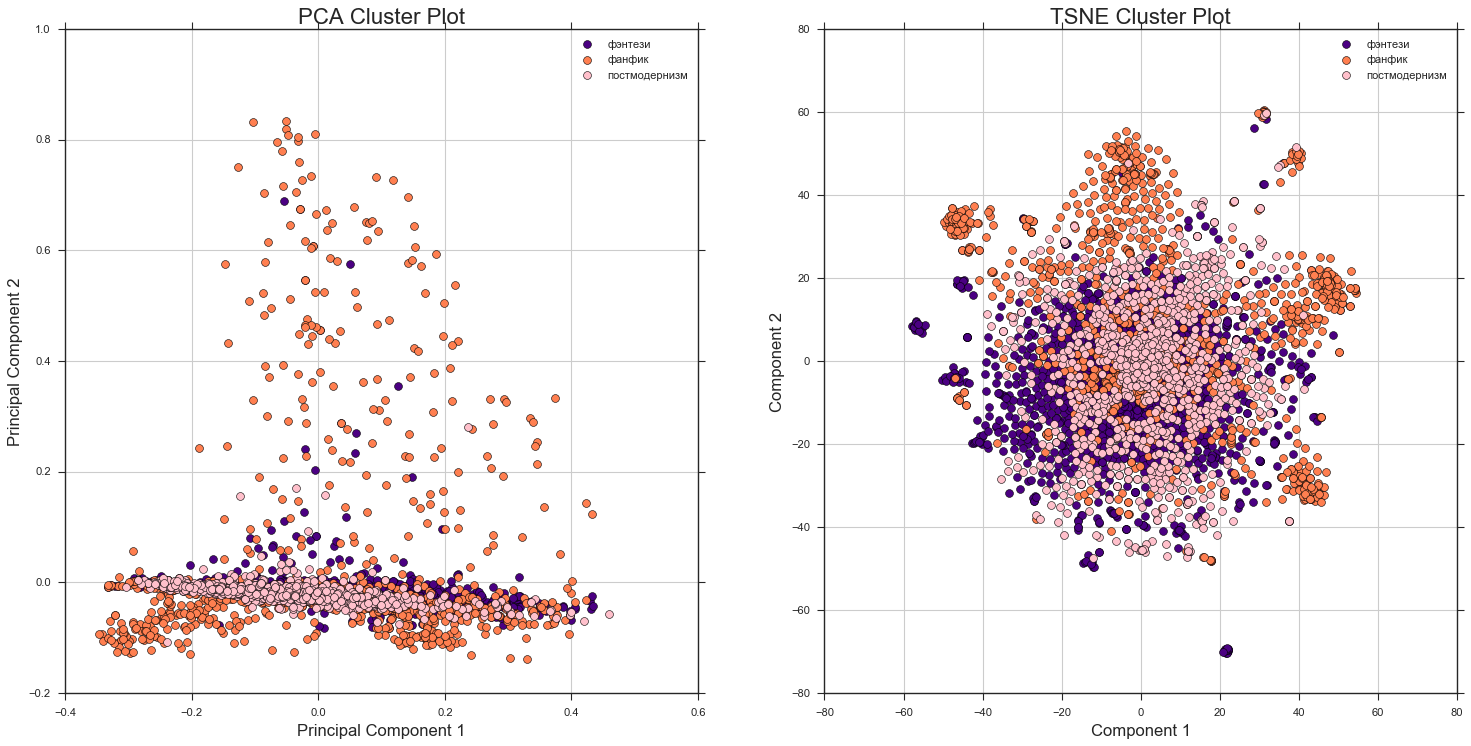

In [339]:
def plot_tsne_pca(data):
    
    f, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    # pca
    ax[0].set_xlabel('Principal Component 1', fontsize = 15)
    ax[0].set_ylabel('Principal Component 2', fontsize = 15)
    ax[0].set_title('PCA Cluster Plot', fontsize = 20)
    targets = ['фэнтези', 'фанфик', 'постмодернизм']
    colors = ['indigo', 'coral', 'pink']
    for target, color in zip(targets, colors):
        indicesToKeep = finalDf['genre'] == target
        ax[0].scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50)
    ax[0].legend(targets)
    ax[0].grid()
    
    # tsne
    ax[1].set_xlabel('Component 1', fontsize = 15)
    ax[1].set_ylabel('Component 2', fontsize = 15)
    ax[1].set_title('TSNE Cluster Plot', fontsize = 20)

    targets = ['фэнтези', 'фанфик', 'постмодернизм']
    colors = ['indigo', 'coral', 'pink']
    for target, color in zip(targets, colors):
        indicesToKeep = tsne_df['genre'] == target
        ax[1].scatter(tsne_df.loc[indicesToKeep, 'component 1']
                   , tsne_df.loc[indicesToKeep, 'component 2']
                   , c = color
                   , s = 50)
    ax[1].legend(targets)
    ax[1].grid()

    
plot_tsne_pca(matr)

#### Примеры кода

Использование t-SNE и PCA для визуализации векторов: [ссылка](https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans).





## [6 баллов] Задача о тематическом моделировании



### об LDA




### Постановка задачи
Загрузите [коллекцию писем Х. Клинтон](https://www.kaggle.com/kaggle/hillary-clinton-emails/?select=Emails.csv) с kaggle. Для скачивания может потребоваться регистрация.

Методом LDA выделите несколько тем в переписке Х. Клинтон, дайте им словесное описание. Используйте библиотеку LdaModel из gensim.

#### Критерии

* **2 БАЛЛА**: получены списки ключевых слов, не выглядящие бессмыслицей
* **2 БАЛЛА**: осуществлена визуализация библиотекой pyLDAvis
* **1 БАЛЛ**: предложено осмысленное текстовое описание большинства выделенных тем.
* **1 БАЛЛ**: проведено сравнение LDA, запущенного на CountVectorizer и TfIdfVectorizer предтавлениях одних и тех же данных. 

#### примеры кода

Пример обучения LdaModel на выдаче CountVectorizer: [ссылка](https://github.com/EricSchles/sklearn_gensim_example/blob/master/example.py)

Пример использования pyLDAvis: секция 15 [по ссылке](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

---

Для обучения *LdaModel* и её последующей визуализации потребуется словарь формата gensim. Словарь формата gensim удобно получать из сжатого csc_matrix-представления нашего векторизованного текста: как многие замечали на паре, tf-idf векторы содержат много нулей.

```python
import gensim
from scipy.sparse import csc

corpus = gensim.matutils.Sparse2Corpus(csc.csc_matrix(X))
dictionary = gensim.corpora.Dictionary.from_corpus(corpus, vocab_dict)
```

где *corpora* содержит полученное с помощью gensim представление коллекции, а *vocab_dict* — это dict, полученный после работы Vectorizer, ставящий в соответствие каждому номеру строки в матрице данных само слово в виде строки.

In [3]:
dataset = pd.read_csv('Emails.csv', encoding='utf-8')

In [4]:
dataset.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


Вроде бы нигде не обговаривалось, какую именно колонку необходимо брать, поэтому я решила, что оптимальным взять колонку ExtractedBodyText, результаты +- можно интерпретировать

In [81]:
def get_tokens_2(text):
    """
    убираем токены и пунктуацию
    """
    tokenized_text = tokenize(text)
    tokens = list(tokenized_text)
    text_token = [_.text for _ in tokens]
    text_end = ' '.join(
            [wrd.lower() for wrd in text_token if wrd.lower() not in stopwords.words(
                "english")])
    # для удаления тегов
    p = re.compile(r'<.*?>')
    new_text = p.sub('', text_end)
    # эмейлов
    p_1 = re.compile(r'\S*@\S*\s?')
    new_text_1 = p_1.sub('', text_end)
    line = "".join(l for l in new_text_1 if l not in (
        '.', ',', '[', ']', '', '«', '»', '±', '№', '€',
        '/', '#',  '_', '%', '@', '^', '&', '*', '{', '}', 
        '?', '!', ':', ';', '—', '--', '<', '>', '"', '(', ')'))
    return line

In [82]:
tokenizing_texts_2 = []
for text in tqdm(dataset['ExtractedBodyText']):
    tokenizing_texts_2.append(get_tokens_2(str(text)))

In [84]:
dataset["tokenized_text"] = tokenizing_texts_2

In [85]:
from nltk.stem import WordNetLemmatizer

In [86]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/macbook/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [87]:
lemmatizer_eng = WordNetLemmatizer()

In [88]:
def get_lemmas_2(text):
    new_l = ''
    
    for word in text.split():
        wrd = lemmatizer_eng.lemmatize(word)
        try:
            new_w = b'%s'%(wrd).decode('utf-8')
            new_l += new_w + ' '
        except:
            new_l += wrd + ' '
    """
    можно убрать числа, чтобы они не мешали
    """
    line = new_l.replace('-', '').replace('nan', '').replace("'", '')
    
    fin_line  = re.sub(r"\d+", "", line, flags=re.UNICODE)
        
    return fin_line

In [89]:
lemmatized_texts_2 = []
for text in tqdm(dataset["tokenized_text"]):
    lemmatized_texts_2.append(get_lemmas_2(text))

In [90]:
dataset["lemmatized_text"] = lemmatized_texts_2

In [91]:
dataset.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText,tokenized_text,lemmatized_text
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...,nan,
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...,b 6 thursday march 3 2011 9 45 pm h latest ...,b thursday march pm h latest syria aiding...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,"Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...,thx,thx
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,"Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...,nan,
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...,h hrod 17 clintonemail com friday march 11...,h hrod clintonemail com friday march pm h...


In [141]:
new_r = []
need = ['war', 'say', 'no', 'new', 'en', 'gov',
        'doc', 'go', 'day', 'see', 'get', 'call',
        'pm', 'am', 'fm', 'mr', 'let', 'add', 'sad',
        'one', 'put', 'cell']
for el in dataset.lemmatized_text.tolist():
    n = el.split(' ')
    for n1 in n:
        if len(n1) <= 3:
            if n1 not in new_r and n1 not in need:
                new_r.append(n1)

In [142]:
new_r[:25]

['',
 'b',
 'h',
 'sid',
 'hrc',
 'thx',
 'com',
 'fw',
 'pi',
 '•',
 'g',
 'lte',
 'u',
 'f',
 'c',
 'cb',
 'fyi',
 'fwd',
 'nfz',
 'nyt',
 'col',
 'tow',
 'n',
 'gen',
 'k']

В данных текстах очень много однобуквенных, двубуквенных и трехбуквенных слов, которые являеются сокращениями/аббревиатурами к чему-то (так как тематика - эмейлы), я предлагаю их игнорировать (оставим достаточно частотные трехсловные слова: вывела имперически путем проб разных моделей lda). Без этого, построить классы будет проще, поэтому стоит попробовать, чтобы хорошо интерпретировать. (тем не менее, если этого не делать, то у нас получится в обоих случаях класс, в большинстве состоящий из аббревитаур и т.д.)

In [143]:
without_abbr = []
for text in tqdm(dataset["lemmatized_text"]):
    line = " ".join(l for l in text.split() if l not in new_r)
    without_abbr.append(line)

In [144]:
dataset["text_clean_tr"] = without_abbr

In [145]:
dataset.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText,tokenized_text,lemmatized_text,text_clean_tr
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...,nan,,
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...,b 6 thursday march 3 2011 9 45 pm h latest ...,b thursday march pm h latest syria aiding...,thursday march pm latest syria aiding qaddafi ...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,"Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...,thx,thx,
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,"Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...,nan,,
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...,h hrod 17 clintonemail com friday march 11...,h hrod clintonemail com friday march pm h...,hrod clintonemail friday march pm huma abedin ...


In [124]:
import gensim
from scipy.sparse import csc

##### CountVectorizer

In [125]:
from sklearn.feature_extraction.text import CountVectorizer

In [146]:
vectorizer_2 = CountVectorizer()

In [147]:
X_1 = vectorizer_2.fit_transform(dataset.text_clean_tr.tolist())

In [148]:
X_1

<7945x24389 sparse matrix of type '<class 'numpy.int64'>'
	with 197948 stored elements in Compressed Sparse Row format>

In [149]:
from gensim import matutils
from gensim.models.ldamodel import LdaModel

In [177]:
lda1 = LdaModel(matutils.Sparse2Corpus(X_1.T), num_topics=5,
                    passes=10,
                    id2word=dict([(
                        i, s) for i, s in enumerate(
                        vectorizer_2.get_feature_names())]),
                per_word_topics=True)

In [151]:
lda1.print_topics()

[(0,
  '0.011*"sent" + 0.010*"email" + 0.008*"message" + 0.008*"part" + 0.008*"release" + 0.007*"blackberry" + 0.005*"north" + 0.004*"book" + 0.004*"see" + 0.004*"korea"'),
 (1,
  '0.006*"american" + 0.005*"obama" + 0.005*"state" + 0.005*"would" + 0.005*"one" + 0.004*"israel" + 0.004*"new" + 0.004*"policy" + 0.004*"president" + 0.004*"government"'),
 (2,
  '0.008*"state" + 0.007*"would" + 0.007*"also" + 0.007*"know" + 0.006*"get" + 0.006*"work" + 0.006*"see" + 0.006*"call" + 0.005*"want" + 0.005*"need"'),
 (3,
  '0.062*"pm" + 0.037*"state" + 0.027*"secretary" + 0.026*"office" + 0.021*"gov" + 0.015*"call" + 0.014*"meeting" + 0.012*"room" + 0.012*"department" + 0.010*"cheryl"'),
 (4,
  '0.011*"republican" + 0.010*"party" + 0.009*"obama" + 0.007*"said" + 0.007*"vote" + 0.006*"democrat" + 0.005*"house" + 0.005*"election" + 0.005*"senate" + 0.005*"would"')]

---
[(0,
  '0.011*"sent" + 0.010*"email" + 0.008*"message" + 0.008*"part" + 0.008*"release" + 0.007*"blackberry" + 0.005*"north" + 0.004*"book" + 0.004*"see" + 0.004*"korea"'),
  
 
 (1,
  '0.006*"american" + 0.005*"obama" + 0.005*"state" + 0.005*"would" + 0.005*"one" + 0.004*"israel" + 0.004*"new" + 0.004*"policy" + 0.004*"president" + 0.004*"government"'),
 
 
 (2,
  '0.008*"state" + 0.007*"would" + 0.007*"also" + 0.007*"know" + 0.006*"get" + 0.006*"work" + 0.006*"see" + 0.006*"call" + 0.005*"want" + 0.005*"need"'),
 
 
 (3,
  '0.062*"pm" + 0.037*"state" + 0.027*"secretary" + 0.026*"office" + 0.021*"gov" + 0.015*"call" + 0.014*"meeting" + 0.012*"room" + 0.012*"department" + 0.010*"cheryl"'),
 
 
 (4,   '0.011*"republican" + 0.010*"party" + 0.009*"obama" + 0.007*"said" + 0.007*"vote" + 0.006*"democrat" + 0.005*"house" + 0.005*"election" + 0.005*"senate" + 0.005*"would"')]
 
---

Самым оптимальным кажется попробовать разбить **на 5 групп**:


* 0 топик: входят слова, которые могут быть связаны с текстами/сообщениями/книгами: сообщение, эмейл, часть (=часть текста - подходит), релиз (=выпуск, например, книги), blackberry (=например, телефон). Остальные слова могут быть связаны косвенно с этим: "смотреть", может означать визуальное восприятие текстов писем, книг, эмейлов, "север"/"Корея" - могут быть темами всех текстов, предложений, книг и т.д. То есть, можно предположить, что это - тематика текстов о севере и Корее (например, про ккаую-нибудь угрозу) --> тематика текстов сообщений, книг и эмейлов (связанных с севером и Кореей)


* 1 топик: входят слова, которые каким-либо образом ассоциируются с Америкой, Обамой и Израилем. То есть, это может быть тематика по намерение американского президента Обамы как-то перенаправить политику государства (США) относительно израильского вопроса --> тематика решения гос вопрсов (Барака Обамы относительно Израиля)


* 2 топик: не очень очевидно, но, кажется, что слова отражают то, как государство(-а)/штаты выражают свою позицию относительно какого-либо вопроса. Например, они видят проблему, понимаю, что им нужно и предпринимают какие-то дейтсвия для решения вопроса --> тематика - государственность


* 3 топик: слова объеденены тематикой каких-либо государственной конференции/собрания: время, государство/штаты, секритариаты, офисы, встречи, комнаты. Все связано с тематикой встреч госудаственных представителей (вероятнее всего, связанных с cheryl) --> тематика - гос собрания


* 4 топик: тематика выборов (либо до президенства Обамы, либо после). В любом случае, все слова объеденины тематикой госов, выборов, партий и президентов.  --> тематика - выборы

In [152]:
corpus = gensim.matutils.Sparse2Corpus(csc.csc_matrix(X_1))
dictionary = gensim.corpora.Dictionary.from_corpus(
    corpus,
    id2word=dict([(
        i, s) for i, s in enumerate(
        vectorizer_2.get_feature_names())]))                                

In [135]:
!pip install --quiet pyLDAvis

You should consider upgrading via the '/Users/macbook/anaconda3/bin/python -m pip install --upgrade pip' command.


In [136]:
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

%matplotlib inline

In [162]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda1, corpus, dictionary)
vis

/Users/macbook/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.146391 -0.013506       1        1  39.560268
4      0.143544  0.021690       2        1  29.773092
2      0.076266 -0.094987       3        1  17.437012
3     -0.238555 -0.154974       4        1   7.128072
0     -0.127645  0.241778       5        1   6.101554, topic_info=      Category         Freq       Term        Total  loglift  logprob
16296  Default  1405.000000         pm  1405.000000  30.0000  30.0000
20674  Default  1985.000000      state  1985.000000  29.0000  29.0000
19308  Default   883.000000  secretary   883.000000  28.0000  28.0000
15009  Default   807.000000     office   807.000000  27.0000  27.0000
9132   Default   492.000000        gov   492.000000  26.0000  26.0000
...        ...          ...        ...          ...      ...      ...
19338   Topic5    70.503571        see   554.834595   0.7336  -5.5755
19450   Topic5    48.211071       send   156.998032   1.6160  -5.9556
9934    Topic5    51.520786    hillary   237.044800   1.2704  -5.8892
21385   Topic5    46.188080     system   164.457123   1.5267  -5.9984
21727   Topic5    45.682331     thanks   169.744995   1.4840  -6.0094

[375 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
37         4  0.993952   abedin
39         4  0.992355  abedinh
258        1  0.283508  address
258        2  0.048404  address
258        3  0.283508  address
...      ...       ...      ...
24164      1  0.981231   writer
24209      5  0.987218   xpress
24237      1  0.525271     year
24237      2  0.316974     year
24237      3  0.157355     year

[773 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 4, 1])

В результате попыток подобрать самый оптимальный способ задачи lda, лучшим вариантом мне показалось сделать: 


* использовать 5 кластеров (были попытки сделать 3 - но, кажется, это слишком мало, и были поптыки сделать 10 классов - появляется проблема: возможно, корпус недостаточно большой, и, возможно, именно в результате этого некоторые кластеры имеют достаточно много общих элементов, что является трудноинтерпретируемым). Поэтому самым оптимальным варинатом мне показалось брать именно 5 


* passes=10 - эмперическим путем было определено, что 10 - оптимальный вариант, при 15 получаются тематики, которые несколько сложнее интерпретировать.


* тематика политики (государственности) и выборов имеют общие слова с тематикой решения гос вопросов. При этом гос собрания и информации о других странах отличны.


* тематика гос вопоcов (1 - гр.) - самая крупная на графике

##### TF-IDF

In [153]:
vectorizer_3 = TfidfVectorizer()

In [154]:
X_3 = vectorizer_3.fit_transform(dataset.text_clean_tr.tolist())

In [155]:
X_3

<7945x24389 sparse matrix of type '<class 'numpy.float64'>'
	with 197948 stored elements in Compressed Sparse Row format>

In [175]:
lda2 = LdaModel(matutils.Sparse2Corpus(X_3.T), num_topics=5,
                passes=10,
                id2word=dict([(
                    i, s) for i, s in enumerate(
                    vectorizer_3.get_feature_names())]),
                per_word_topics=True)

In [176]:
lda2.print_topics()

[(0,
  '0.017*"print" + 0.006*"pm" + 0.004*"calling" + 0.004*"office" + 0.003*"importance" + 0.003*"high" + 0.003*"roger" + 0.003*"arrive" + 0.002*"secretary" + 0.002*"en"'),
 (1,
  '0.008*"release" + 0.007*"part" + 0.002*"declassify" + 0.002*"anytime" + 0.002*"nice" + 0.002*"great" + 0.002*"lavrov" + 0.001*"lock" + 0.001*"sigh" + 0.001*"reason"'),
 (2,
  '0.008*"call" + 0.005*"see" + 0.004*"get" + 0.004*"know" + 0.003*"talk" + 0.003*"tomorrow" + 0.003*"state" + 0.003*"would" + 0.003*"work" + 0.003*"time"'),
 (3,
  '0.016*"gov" + 0.013*"state" + 0.009*"pm" + 0.008*"mill" + 0.008*"cheryl" + 0.008*"clintonemail" + 0.008*"hrod" + 0.007*"abedin" + 0.006*"millscd" + 0.006*"huma"'),
 (4,
  '0.005*"lauren" + 0.002*"jiloty" + 0.002*"joanne" + 0.002*"grid" + 0.002*"done" + 0.001*"laszczych" + 0.001*"delivered" + 0.001*"message" + 0.001*"recipient" + 0.001*"isabelle"')]

---
[(0,
  '0.017*"print" + 0.006*"pm" + 0.004*"calling" + 0.004*"office" + 0.003*"importance" + 0.003*"high" + 0.003*"roger" + 0.003*"arrive" + 0.002*"secretary" + 0.002*"en"'),
 
 
 (1,
  '0.008*"release" + 0.007*"part" + 0.002*"declassify" + 0.002*"anytime" + 0.002*"nice" + 0.002*"great" + 0.002*"lavrov" + 0.001*"lock" + 0.001*"sigh" + 0.001*"reason"'),
 
 
 (2,
  '0.008*"call" + 0.005*"see" + 0.004*"get" + 0.004*"know" + 0.003*"talk" + 0.003*"tomorrow" + 0.003*"state" + 0.003*"would" + 0.003*"work" + 0.003*"time"'),
 
 
 (3,
  '0.016*"gov" + 0.013*"state" + 0.009*"pm" + 0.008*"mill" + 0.008*"cheryl" + 0.008*"clintonemail" + 0.008*"hrod" + 0.007*"abedin" + 0.006*"millscd" + 0.006*"huma"'),
 
 
 (4,
  '0.005*"lauren" + 0.002*"jiloty" + 0.002*"joanne" + 0.002*"grid" + 0.002*"done" + 0.001*"laszczych" + 0.001*"delivered" + 0.001*"message" + 0.001*"recipient" + 0.001*"isabelle"')]

---

Самым оптимальным кажется попробовать разбить **на 5 групп**:


* 0 топик: кажется, тематика как-то связана с государственными собраниями, связанных с roger и его прибытием на них. Но, если смотреть шире, тематика гос совещаний/собраний, при условии, что указывается время встреч, важность этих собраний и язык, на котором ведется коммуникация --> собрания гос важности (с roger)


* 1 топик: похоже, что данные слова связаны с тематикой рассекречивания и выпуска каких-то документов относительно иностранных для Америки политических деятелях. Тут указан релиз, рассекречивание части (вероятно, каких-то данных), Лаврова, причины и оценочных характеристик (отлично, прекрасно, вздохнуть). Таким образом, если обобщать --> тематика релиза (засекреченной) информации гос важности (и ее оценивание)


* 2 топик: по аналогии с предыдущей lda, подобный кластер сложно описать просто, поэтому я бы ориентировалась на то, что тут собраны некоторые вопросы, которые говорят о государстве/штате и о обсуждении и работе в течение какого-то вреени над какими-то проблемами/вопросами. Похоже, что можно обозачить как --> тематика государственности


* 3 топик: сложно определить общую тему, но похоже, что может быть связано с получением на мейл Клинтон сообщений о работе каких-то других политический активистов (Хумы Абедин), в государстве/штате. Таким образом, я бы объединила этот кластер под тематиков --> политический деятели и информация о них  (как увидим на графике, информация о времени, может быть, выступлений, а может быть влияния других пол. деятелей + возможно, какие-то встречи)


* 4 топик: тематика отчасти похожа на предыдущую, то есть дана информация о письмах и людях, которые могли их получать/отправлять. Это отлично от вышеописаного кластера тем, что тут содержаться реакции на письма: отправлено, например, сетка отправлений. То есть, информация более деловая и общая. --> сообщения (сетка)

In [164]:
corpus_2 = gensim.matutils.Sparse2Corpus(csc.csc_matrix(X_3))
dictionary_2 = gensim.corpora.Dictionary.from_corpus(
    corpus_2,
    id2word=dict([(
        i, s) for i, s in enumerate(
        vectorizer_3.get_feature_names())]))   

In [165]:
pyLDAvis.enable_notebook()
vis2 = pyLDAvis.gensim.prepare(lda2, corpus_2, dictionary_2)
vis2

/Users/macbook/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.177474  0.000326       1        1  60.097122
0      0.046887  0.031488       2        1  13.270624
4      0.043062  0.017529       3        1   9.999023
1      0.043608  0.020684       4        1   8.715829
3      0.043917 -0.070027       5        1   7.917401, topic_info=      Category       Freq     Term      Total  loglift  logprob
20674  Default  62.000000    state  62.000000  30.0000  30.0000
16806  Default  51.000000    print  51.000000  29.0000  29.0000
9132   Default  33.000000      gov  33.000000  28.0000  28.0000
16296  Default  62.000000       pm  62.000000  27.0000  27.0000
18002  Default  22.000000  release  22.000000  26.0000  26.0000
...        ...        ...      ...        ...      ...      ...
8586    Topic5   5.452415   friday  15.018083   1.5229  -5.7200
11441   Topic5   4.028399  january   8.876332   1.7461  -6.0227
22437   Topic5   4.564573  tuesday  13.406467   1.4587  -5.8978
1212    Topic5   3.481424    april   7.888569   1.7181  -6.1686
13929   Topic5   4.915996   monday  21.854740   1.0442  -5.8236

[236 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
37         5  0.969030    abedin
39         5  0.935194   abedinh
286        3  1.080480   adlerce
522        1  0.308608   airport
522        2  0.617215   airport
...      ...       ...       ...
24112      4  0.521643     worry
24130      1  0.980786     would
24209      5  0.798583    xpress
24236      5  0.964796      yeah
24274      3  0.821115  yohannes

[273 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 2, 4])

По аналогии с lda: 


* использованы 5 кластеров


* passes=10


* данные те же самые, что и для lda (на countvectorizer) 


* тематика релиза (засекреченных) данных имеет пересечения с тематикой собраний госважности и деловой перепиской (деловыми документами/их сеткой). При этом информация о полит. деятелях (+- встреч, класс 5 на график) и тематика государственности (класс 1 на гр.) обособлены.


* тематика государственности (1 на гр.) - самая крупная на графике

##### Сравнение CountVectorizer VS TF-IDF:

---

Есть ощущение, что CountVectorizer работает несколько лучше: классы, которые он определяет более четкие тематики (в том числе допускается значительно меньшее количество пересечений, если они есть, то не такие крупные как у tf-idf).


Особенно это было заметно тогда, когда не были удалены слова длиной 3 и меньше: tf-idf выдавал значительно больше мусора, чем CountVectorizer (ниже будет приведен пример таких классов (без такой очистки): считать результат с CountVectorizer значительно проще).


Несмотря на то, что для задания использовали одни и те же данные, результаты применения lda на разных векторайзерах получились совсем разные: тематики, выделенные ими похожи только отчасти (собрания гос важности и тематика государственности), в остальном, кажется, что тематики сильно отличаются: например, в CountVectorizer есть тематика выборов, которую не видим tf-idf (зато в нем есть тематика (засекреченных) документов, чего не видит CountVectorizer).


Таким образом, данные, которые получились - отличны: только в некоторых моментах результаты похожи, но, кажется, что CountVectorizer работает чуть более чисто, чем tf-idf.




##### Доп примеры

In [166]:
# tf-idf на лемматизированных текстах

vectorizer_4 = TfidfVectorizer()
X_4 = vectorizer_4.fit_transform(dataset.lemmatized_text.tolist())

In [169]:
lda4 = LdaModel(matutils.Sparse2Corpus(X_4.T), num_topics=5,
                passes=10,
                id2word=dict([(
                    i, s) for i, s in enumerate(
                    vectorizer_4.get_feature_names())]),
                per_word_topics=True)

In [168]:
lda4.print_topics()

[(0,
  '0.064*"fyi" + 0.014*"gov" + 0.012*"state" + 0.008*"pm" + 0.007*"fw" + 0.007*"cheryl" + 0.006*"mill" + 0.006*"hrod" + 0.006*"clintonemail" + 0.006*"release"'),
 (1,
  '0.015*"call" + 0.012*"pls" + 0.010*"print" + 0.009*"thx" + 0.006*"pi" + 0.005*"talk" + 0.004*"see" + 0.004*"tomorrow" + 0.004*"hillary" + 0.004*"yes"'),
 (2,
  '0.005*"pm" + 0.005*"office" + 0.003*"secretary" + 0.002*"arrive" + 0.002*"room" + 0.002*"en" + 0.002*"please" + 0.002*"route" + 0.002*"depart" + 0.002*"min"'),
 (3,
  '0.010*"yes" + 0.002*"faxed" + 0.001*"joanne" + 0.001*"berry" + 0.001*"delivered" + 0.001*"xo" + 0.001*"verizon" + 0.001*"message" + 0.001*"jpg" + 0.001*"laszczych"'),
 (4,
  '0.008*"ok" + 0.003*"good" + 0.003*"would" + 0.003*"see" + 0.003*"call" + 0.003*"get" + 0.003*"state" + 0.003*"think" + 0.002*"know" + 0.002*"time"')]

In [170]:
# CountVectorizer на лемматизированных текстах

vectorizer_5 = CountVectorizer()
X_5 = vectorizer_5.fit_transform(dataset.lemmatized_text.tolist())

In [174]:
lda5 = LdaModel(matutils.Sparse2Corpus(X_5.T), num_topics=5,
                passes=10,
                id2word=dict([(
                    i, s) for i, s in enumerate(
                    vectorizer_5.get_feature_names())]),
                per_word_topics=True)

In [173]:
lda5.print_topics()

[(0,
  '0.055*"pm" + 0.031*"state" + 0.024*"secretary" + 0.023*"office" + 0.019*"gov" + 0.012*"meeting" + 0.011*"room" + 0.009*"department" + 0.009*"call" + 0.008*"cheryl"'),
 (1,
  '0.009*"republican" + 0.009*"obama" + 0.005*"said" + 0.005*"house" + 0.005*"democrat" + 0.005*"party" + 0.005*"president" + 0.005*"would" + 0.005*"senate" + 0.004*"vote"'),
 (2,
  '0.009*"call" + 0.009*"fyi" + 0.007*"know" + 0.007*"see" + 0.007*"would" + 0.007*"get" + 0.007*"work" + 0.007*"also" + 0.006*"want" + 0.006*"israel"'),
 (3,
  '0.019*"state" + 0.007*"department" + 0.006*"security" + 0.006*"united" + 0.006*"government" + 0.005*"people" + 0.004*"afghanistan" + 0.004*"effort" + 0.004*"country" + 0.004*"information"'),
 (4,
  '0.005*"obama" + 0.005*"would" + 0.005*"said" + 0.005*"one" + 0.005*"new" + 0.005*"president" + 0.004*"american" + 0.004*"time" + 0.004*"say" + 0.004*"mr"')]